# 📊 Store Sales Time Series Forecasting

## 🎯 Competition Overview

In this competition, we will predict sales for thousands of product families sold at **Favorita stores** located in Ecuador. The training data includes dates, store and product information, promotional status, and sales numbers. Additional supplementary files are provided to enhance model building.

---

## 📁 File Descriptions and Data Fields

### 📈 **train.csv**
The training data comprises time series of features and the target variable:
- **`store_nbr`**: Identifies the store at which the products are sold
- **`family`**: Identifies the type of product sold
- **`sales`**: Total sales for a product family at a particular store on a given date
  - *Fractional values are possible* (e.g., 1.5 kg of cheese)
- **`onpromotion`**: Total number of items in a product family being promoted at a store on a given date

### 🧪 **test.csv**
The test data contains the same features as the training data. The objective is to predict the target **`sales`** for the dates in this file.
- The dates in the test data cover the **15 days** after the last date in the training data

### 📝 **sample_submission.csv**
A sample submission file in the correct format for competition submissions

### 🏪 **stores.csv**
Store metadata providing additional context:
- **`city`**: City where the store is located
- **`state`**: State where the store is located
- **`type`**: Type of store
- **`cluster`**: Grouping of similar stores

### 🛢️ **oil.csv**
Daily oil price data spanning both train and test timeframes
- *Ecuador is an oil-dependent country, and its economic health is highly vulnerable to oil price shocks*

### 🎉 **holidays_events.csv**
Holidays and events with detailed metadata

#### ⚠️ **Important Notes on Holidays:**
- **`Transferred`**: A holiday officially falls on a calendar day but was moved to another date by the government
  - Transferred days behave more like normal days than holidays
  - To find the actual celebration date, look for the corresponding row where `type` is `Transfer`
  - *Example*: Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12 (celebrated on 2012-10-12)
- **`Bridge`**: Extra days added to extend a holiday (e.g., long weekend)
  - Often compensated by `Work Day` type (a normally non-working day scheduled for work)
- **`Additional`**: Extra days added to regular calendar holidays (e.g., Christmas Eve)

---

## 📌 Additional Important Notes

### 💰 **Wage Payment Schedule**
- Public sector wages are paid **every two weeks** on the **15th** and on the **last day of the month**
- This payment schedule may significantly affect supermarket sales patterns

### 🌍 **2016 Ecuador Earthquake**
- A **magnitude 7.8 earthquake** struck Ecuador on **April 16, 2016**
- Relief efforts led to mass donations of water and essential products
- Supermarket sales were **greatly affected for several weeks** following the earthquake

---

<div align="center">


---

[![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/sajjad-ali-shah47/)
[![Kaggle](https://img.shields.io/badge/Kaggle-Dataset-20BEFF?style=for-the-badge&logo=kaggle&logoColor=white)](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

---

**Author:** Sajjad Ali Shah | **Project Type:** Time Series Forecasting | **Tools:** Python, Pandas, Scikit-learn

</div>

In [1]:
# import the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import the time series library
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# import the forecasting library
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# import the metrics library
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import the warnings library
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the datasets
train = pd.read_csv(r'Dataset\train.csv')
test = pd.read_csv(r'Dataset\test.csv')
stores = pd.read_csv(r'Dataset\stores.csv')
oil = pd.read_csv(r'Dataset\oil.csv')
holidays_events = pd.read_csv(r'Dataset\holidays_events.csv')
transactions = pd.read_csv(r'Dataset\transactions.csv')
sample_submission = pd.read_csv(r'D:\LLM and AIOps Projects\Time-Series-Projects-Hub\StoreSales Time Series Forecasting\Dataset\sample_submission.csv')

print("✅ Datasets loaded successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"   • Train: {train.shape}")
print(f"   • Test: {test.shape}")
print(f"   • Stores: {stores.shape}")
print(f"   • Oil: {oil.shape}")
print(f"   • Holidays/Events: {holidays_events.shape}")
print(f"   • Transactions: {transactions.shape}")
print(f"   • Sample Submission: {sample_submission.shape}")

✅ Datasets loaded successfully!

📊 Dataset Shapes:
   • Train: (3000888, 6)
   • Test: (28512, 5)
   • Stores: (54, 5)
   • Oil: (1218, 2)
   • Holidays/Events: (350, 6)
   • Transactions: (83488, 3)
   • Sample Submission: (28512, 2)


---

## 🔍 Exploratory Data Analysis (EDA)

### Step 1: Understanding the Training Data

Let's start by exploring our main dataset - the training data with sales information.

In [4]:
# Display first few rows and basic information
print("=" * 80)
print("📊 TRAINING DATA - FIRST 5 ROWS")
print("=" * 80)
display(train.head())

print("\n" + "=" * 80)
print("📋 TRAINING DATA - INFO")
print("=" * 80)
train.info()

print("\n" + "=" * 80)
print("📈 TRAINING DATA - STATISTICAL SUMMARY")
print("=" * 80)
display(train.describe())

print("\n" + "=" * 80)
print("🔍 MISSING VALUES")
print("=" * 80)
missing_train = train.isnull().sum()
missing_pct = (missing_train / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Percentage (%)': missing_pct
})
display(missing_df[missing_df['Missing Count'] > 0])

📊 TRAINING DATA - FIRST 5 ROWS


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



📋 TRAINING DATA - INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB

📈 TRAINING DATA - STATISTICAL SUMMARY


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02



🔍 MISSING VALUES


,Missing Count,Percentage (%)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (362,).

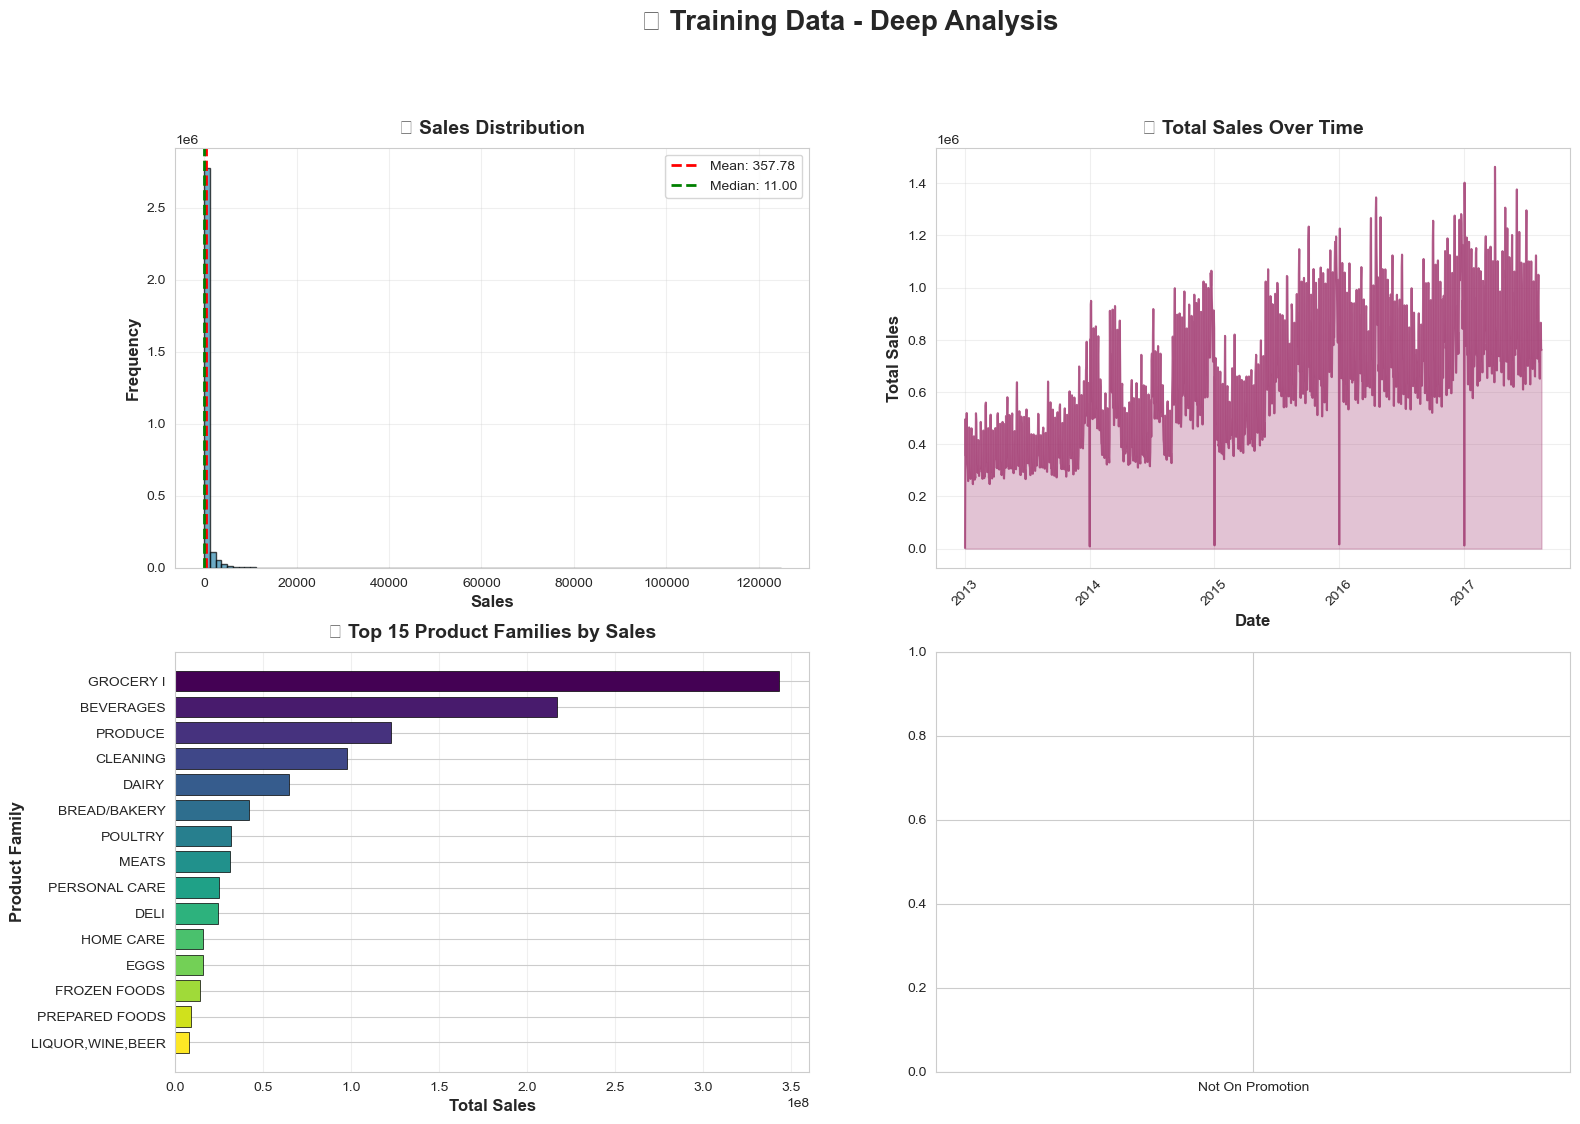

In [5]:
# Convert date column to datetime
train['date'] = pd.to_datetime(train['date'])

# Create professional visualizations for training data
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('🔍 Training Data - Deep Analysis', fontsize=20, fontweight='bold', y=0.995)

# 1. Sales Distribution
ax1 = axes[0, 0]
train['sales'].hist(bins=100, color='#2E86AB', edgecolor='black', alpha=0.7, ax=ax1)
ax1.axvline(train['sales'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train["sales"].mean():.2f}')
ax1.axvline(train['sales'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {train["sales"].median():.2f}')
ax1.set_xlabel('Sales', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('📊 Sales Distribution', fontsize=14, fontweight='bold', pad=10)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Sales Over Time (Aggregated Daily)
ax2 = axes[0, 1]
daily_sales = train.groupby('date')['sales'].sum().reset_index()
ax2.plot(daily_sales['date'], daily_sales['sales'], color='#A23B72', linewidth=1.5, alpha=0.8)
ax2.fill_between(daily_sales['date'], daily_sales['sales'], alpha=0.3, color='#A23B72')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Sales', fontsize=12, fontweight='bold')
ax2.set_title('📈 Total Sales Over Time', fontsize=14, fontweight='bold', pad=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

# 3. Top 15 Product Families by Sales
ax3 = axes[1, 0]
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False).head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(family_sales)))
bars = ax3.barh(family_sales.index, family_sales.values, color=colors, edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Total Sales', fontsize=12, fontweight='bold')
ax3.set_ylabel('Product Family', fontsize=12, fontweight='bold')
ax3.set_title('🏆 Top 15 Product Families by Sales', fontsize=14, fontweight='bold', pad=10)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. OnPromotion Analysis
ax4 = axes[1, 1]
promo_effect = train.groupby('onpromotion')['sales'].mean()
colors_promo = ['#FF6B6B', '#4ECDC4']
bars = ax4.bar(['Not On Promotion', 'On Promotion'], promo_effect.values, color=colors_promo, 
               edgecolor='black', linewidth=2, alpha=0.8, width=0.6)
ax4.set_ylabel('Average Sales', fontsize=12, fontweight='bold')
ax4.set_title('🎯 Impact of Promotions on Sales', fontsize=14, fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Training data visualizations completed!")

---

### Step 2: Store Information Analysis

Let's analyze the store metadata to understand the distribution and characteristics of stores.

In [6]:
# Display stores data
print("=" * 80)
print("🏪 STORES DATA")
print("=" * 80)
display(stores)

print("\n" + "=" * 80)
print("📊 STORES SUMMARY")
print("=" * 80)
print(f"Total Stores: {stores.shape[0]}")
print(f"\nStore Types: {stores['type'].nunique()}")
print(stores['type'].value_counts())
print(f"\nCities: {stores['city'].nunique()}")
print(f"States: {stores['state'].nunique()}")
print(f"Clusters: {stores['cluster'].nunique()}")

🏪 STORES DATA


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15



📊 STORES SUMMARY
Total Stores: 54

Store Types: 5
type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

Cities: 22
States: 16
Clusters: 17


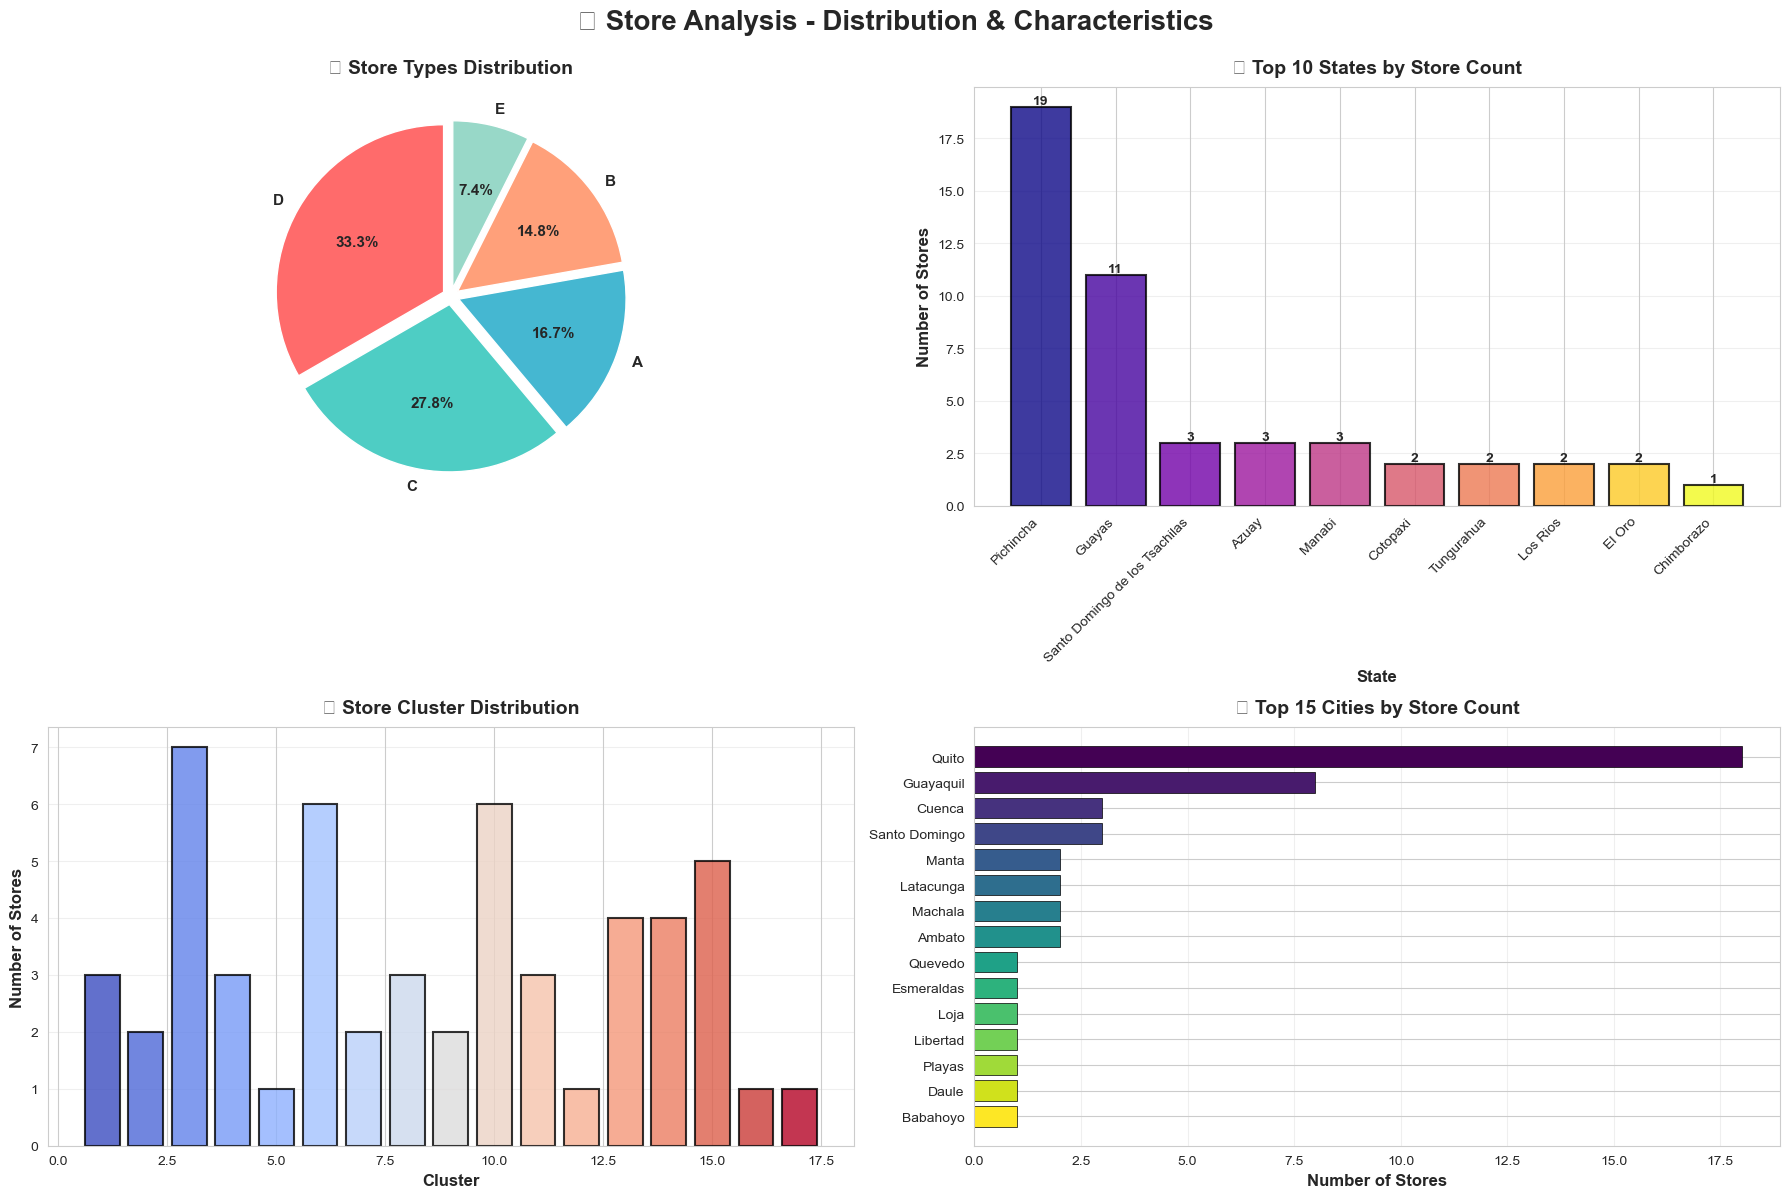


✅ Store analysis visualizations completed!


In [7]:
# Professional visualizations for stores
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('🏪 Store Analysis - Distribution & Characteristics', fontsize=20, fontweight='bold', y=0.995)

# 1. Store Types Distribution
ax1 = axes[0, 0]
store_types = stores['type'].value_counts()
colors_types = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
wedges, texts, autotexts = ax1.pie(store_types.values, labels=store_types.index, autopct='%1.1f%%',
                                     colors=colors_types, startangle=90, explode=[0.05]*len(store_types),
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('🏬 Store Types Distribution', fontsize=14, fontweight='bold', pad=10)

# 2. Stores by State
ax2 = axes[0, 1]
state_counts = stores['state'].value_counts().head(10)
colors_state = plt.cm.plasma(np.linspace(0, 1, len(state_counts)))
bars = ax2.bar(range(len(state_counts)), state_counts.values, color=colors_state, 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(state_counts)))
ax2.set_xticklabels(state_counts.index, rotation=45, ha='right')
ax2.set_xlabel('State', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Stores', fontsize=12, fontweight='bold')
ax2.set_title('📍 Top 10 States by Store Count', fontsize=14, fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Cluster Distribution
ax3 = axes[1, 0]
cluster_counts = stores['cluster'].value_counts().sort_index()
colors_cluster = plt.cm.coolwarm(np.linspace(0, 1, len(cluster_counts)))
bars = ax3.bar(cluster_counts.index, cluster_counts.values, color=colors_cluster, 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Stores', fontsize=12, fontweight='bold')
ax3.set_title('🎯 Store Cluster Distribution', fontsize=14, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)

# 4. City Distribution (Top 15)
ax4 = axes[1, 1]
city_counts = stores['city'].value_counts().head(15)
colors_city = plt.cm.viridis(np.linspace(0, 1, len(city_counts)))
ax4.barh(range(len(city_counts)), city_counts.values, color=colors_city, 
         edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(city_counts)))
ax4.set_yticklabels(city_counts.index, fontsize=10)
ax4.set_xlabel('Number of Stores', fontsize=12, fontweight='bold')
ax4.set_title('🌆 Top 15 Cities by Store Count', fontsize=14, fontweight='bold', pad=10)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Store analysis visualizations completed!")

---

### Step 3: Oil Price Analysis

Ecuador's economy is oil-dependent. Let's analyze how oil prices fluctuate and their potential impact.

In [8]:
# Analyze oil prices
oil['date'] = pd.to_datetime(oil['date'])

print("=" * 80)
print("🛢️ OIL PRICE DATA")
print("=" * 80)
display(oil.head(10))

print("\n" + "=" * 80)
print("📊 OIL PRICE STATISTICS")
print("=" * 80)
print(f"Date Range: {oil['date'].min()} to {oil['date'].max()}")
print(f"Total Records: {len(oil)}")
print(f"Missing Values: {oil['dcoilwtico'].isnull().sum()} ({(oil['dcoilwtico'].isnull().sum()/len(oil)*100):.2f}%)")
print(f"\nPrice Statistics:")
display(oil['dcoilwtico'].describe())

🛢️ OIL PRICE DATA


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27



📊 OIL PRICE STATISTICS
Date Range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Total Records: 1218
Missing Values: 43 (3.53%)

Price Statistics:


count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64

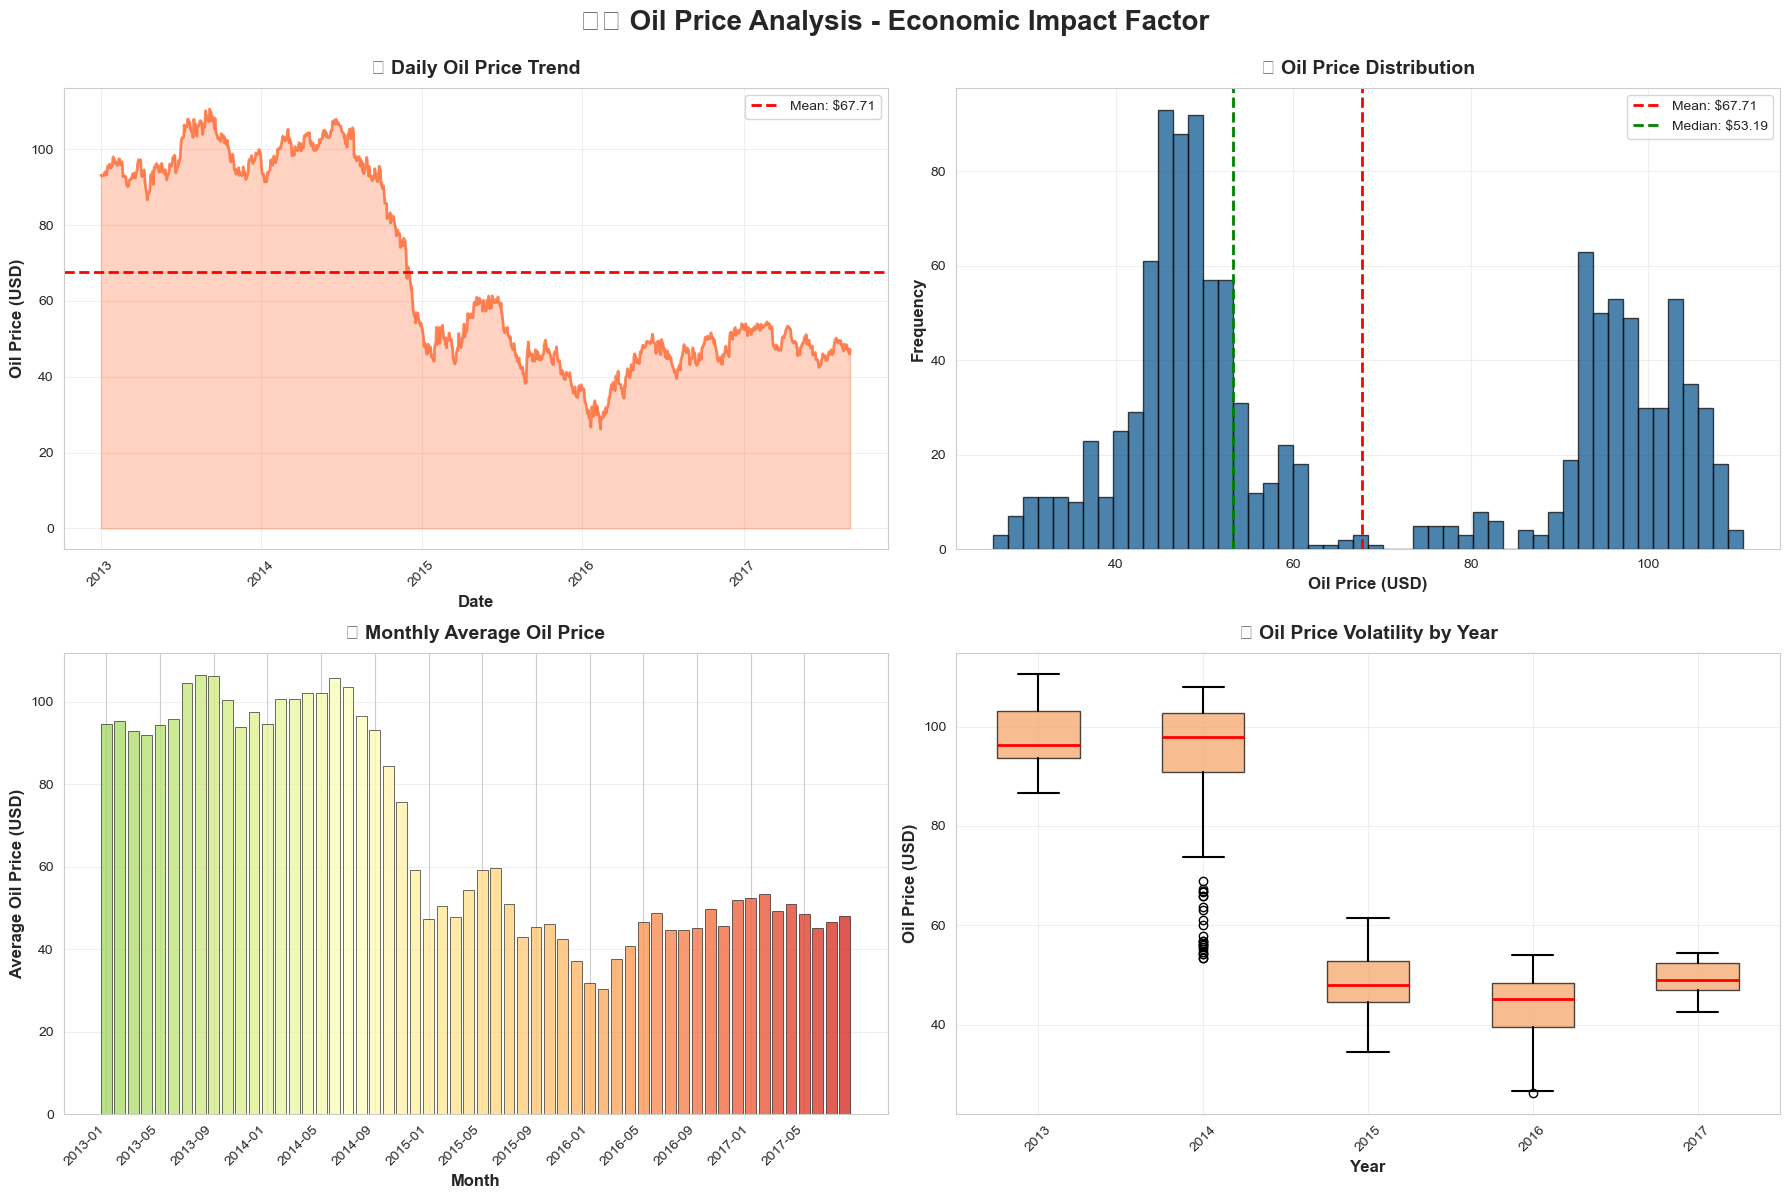


✅ Oil price analysis visualizations completed!


In [9]:
# Professional oil price visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('🛢️ Oil Price Analysis - Economic Impact Factor', fontsize=20, fontweight='bold', y=0.995)

# 1. Oil Price Over Time
ax1 = axes[0, 0]
oil_clean = oil.dropna()
ax1.plot(oil_clean['date'], oil_clean['dcoilwtico'], color='#FF6B35', linewidth=2, alpha=0.8)
ax1.fill_between(oil_clean['date'], oil_clean['dcoilwtico'], alpha=0.3, color='#FF6B35')
ax1.axhline(oil_clean['dcoilwtico'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${oil_clean["dcoilwtico"].mean():.2f}')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Oil Price (USD)', fontsize=12, fontweight='bold')
ax1.set_title('📈 Daily Oil Price Trend', fontsize=14, fontweight='bold', pad=10)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Oil Price Distribution
ax2 = axes[0, 1]
ax2.hist(oil_clean['dcoilwtico'], bins=50, color='#004E89', edgecolor='black', alpha=0.7)
ax2.axvline(oil_clean['dcoilwtico'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${oil_clean["dcoilwtico"].mean():.2f}')
ax2.axvline(oil_clean['dcoilwtico'].median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: ${oil_clean["dcoilwtico"].median():.2f}')
ax2.set_xlabel('Oil Price (USD)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('📊 Oil Price Distribution', fontsize=14, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Monthly Average Oil Price
ax3 = axes[1, 0]
oil_clean['year_month'] = oil_clean['date'].dt.to_period('M')
monthly_oil = oil_clean.groupby('year_month')['dcoilwtico'].mean()
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(monthly_oil)))
bars = ax3.bar(range(len(monthly_oil)), monthly_oil.values, color=colors, 
               edgecolor='black', linewidth=0.5, alpha=0.8)
ax3.set_xlabel('Month', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Oil Price (USD)', fontsize=12, fontweight='bold')
ax3.set_title('📅 Monthly Average Oil Price', fontsize=14, fontweight='bold', pad=10)
ax3.set_xticks(range(0, len(monthly_oil), max(1, len(monthly_oil)//12)))
ax3.set_xticklabels([str(monthly_oil.index[i]) for i in range(0, len(monthly_oil), max(1, len(monthly_oil)//12))], 
                     rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Box Plot - Oil Price Volatility
ax4 = axes[1, 1]
oil_clean['year'] = oil_clean['date'].dt.year
years = sorted(oil_clean['year'].unique())
data_by_year = [oil_clean[oil_clean['year'] == year]['dcoilwtico'].values for year in years]
bp = ax4.boxplot(data_by_year, labels=years, patch_artist=True, 
                 boxprops=dict(facecolor='#F4A261', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(color='black', linewidth=1.5),
                 capprops=dict(color='black', linewidth=1.5))
ax4.set_xlabel('Year', fontsize=12, fontweight='bold')
ax4.set_ylabel('Oil Price (USD)', fontsize=12, fontweight='bold')
ax4.set_title('📦 Oil Price Volatility by Year', fontsize=14, fontweight='bold', pad=10)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Oil price analysis visualizations completed!")

---

### Step 4: Holidays & Events Analysis

Understanding holidays and special events is crucial for forecasting sales patterns.

In [10]:
# Analyze holidays and events
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

print("=" * 80)
print("🎉 HOLIDAYS & EVENTS DATA")
print("=" * 80)
display(holidays_events.head(15))

print("\n" + "=" * 80)
print("📊 HOLIDAYS & EVENTS SUMMARY")
print("=" * 80)
print(f"Total Events: {len(holidays_events)}")
print(f"Date Range: {holidays_events['date'].min()} to {holidays_events['date'].max()}")
print(f"\nEvent Types:")
print(holidays_events['type'].value_counts())
print(f"\nLocales:")
print(holidays_events['locale'].value_counts())
print(f"\nLocale Names (Top 10):")
print(holidays_events['locale_name'].value_counts().head(10))

🎉 HOLIDAYS & EVENTS DATA


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False



📊 HOLIDAYS & EVENTS SUMMARY
Total Events: 350
Date Range: 2012-03-02 00:00:00 to 2017-12-26 00:00:00

Event Types:
type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

Locales:
locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

Locale Names (Top 10):
locale_name
Ecuador      174
Quito         13
Riobamba      12
Guaranda      12
Latacunga     12
Ambato        12
Guayaquil     11
Cuenca         7
Ibarra         7
Salinas        6
Name: count, dtype: int64


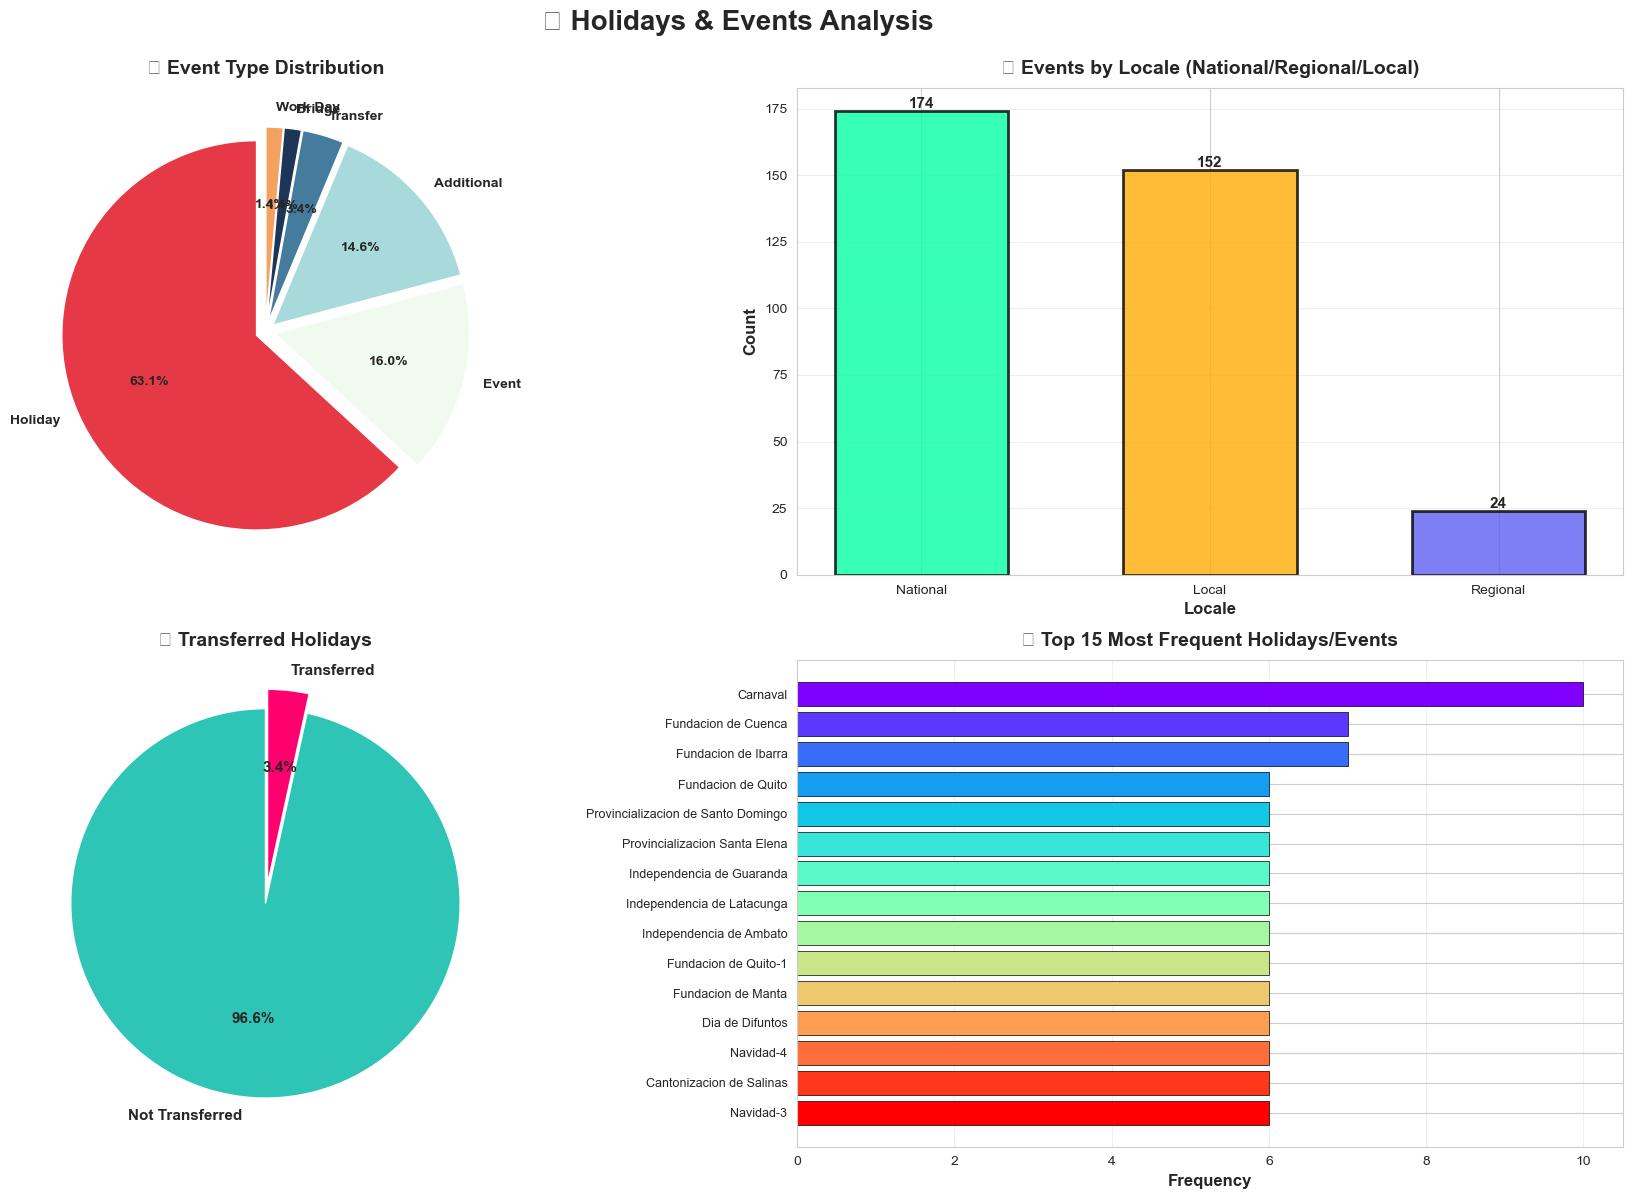


✅ Holidays & events analysis visualizations completed!


In [11]:
# Professional holidays & events visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('🎉 Holidays & Events Analysis', fontsize=20, fontweight='bold', y=0.995)

# 1. Event Types Distribution
ax1 = axes[0, 0]
event_types = holidays_events['type'].value_counts()
colors_events = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D', '#1D3557', '#F4A261']
wedges, texts, autotexts = ax1.pie(event_types.values, labels=event_types.index, autopct='%1.1f%%',
                                     colors=colors_events, startangle=90, explode=[0.05]*len(event_types),
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('📋 Event Type Distribution', fontsize=14, fontweight='bold', pad=10)

# 2. Locale Distribution
ax2 = axes[0, 1]
locale_counts = holidays_events['locale'].value_counts()
colors_locale = ['#06FFA5', '#FFAD05', '#5D5FEF']
bars = ax2.bar(locale_counts.index, locale_counts.values, color=colors_locale, 
               edgecolor='black', linewidth=2, alpha=0.8, width=0.6)
ax2.set_xlabel('Locale', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('🌍 Events by Locale (National/Regional/Local)', fontsize=14, fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Transferred vs Non-transferred
ax3 = axes[1, 0]
transferred_counts = holidays_events['transferred'].value_counts()
colors_transfer = ['#2EC4B6', '#FF006E']
wedges, texts, autotexts = ax3.pie(transferred_counts.values, 
                                     labels=['Not Transferred', 'Transferred'],
                                     autopct='%1.1f%%', colors=colors_transfer, 
                                     startangle=90, explode=[0, 0.1],
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('🔄 Transferred Holidays', fontsize=14, fontweight='bold', pad=10)

# 4. Top 15 Most Common Holiday Descriptions
ax4 = axes[1, 1]
top_holidays = holidays_events['description'].value_counts().head(15)
colors_holidays = plt.cm.rainbow(np.linspace(0, 1, len(top_holidays)))
ax4.barh(range(len(top_holidays)), top_holidays.values, color=colors_holidays, 
         edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(top_holidays)))
ax4.set_yticklabels(top_holidays.index, fontsize=9)
ax4.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('🏆 Top 15 Most Frequent Holidays/Events', fontsize=14, fontweight='bold', pad=10)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Holidays & events analysis visualizations completed!")

---

### Step 5: Transactions Analysis

Let's analyze the transaction data to understand customer activity patterns.

In [12]:
# Analyze transactions
transactions['date'] = pd.to_datetime(transactions['date'])

print("=" * 80)
print("💳 TRANSACTIONS DATA")
print("=" * 80)
display(transactions.head(15))

print("\n" + "=" * 80)
print("📊 TRANSACTIONS SUMMARY")
print("=" * 80)
print(f"Total Records: {len(transactions)}")
print(f"Date Range: {transactions['date'].min()} to {transactions['date'].max()}")
print(f"Unique Stores: {transactions['store_nbr'].nunique()}")
print(f"\nTransaction Statistics:")
display(transactions['transactions'].describe())

💳 TRANSACTIONS DATA


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940



📊 TRANSACTIONS SUMMARY
Total Records: 83488
Date Range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Unique Stores: 54

Transaction Statistics:


count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

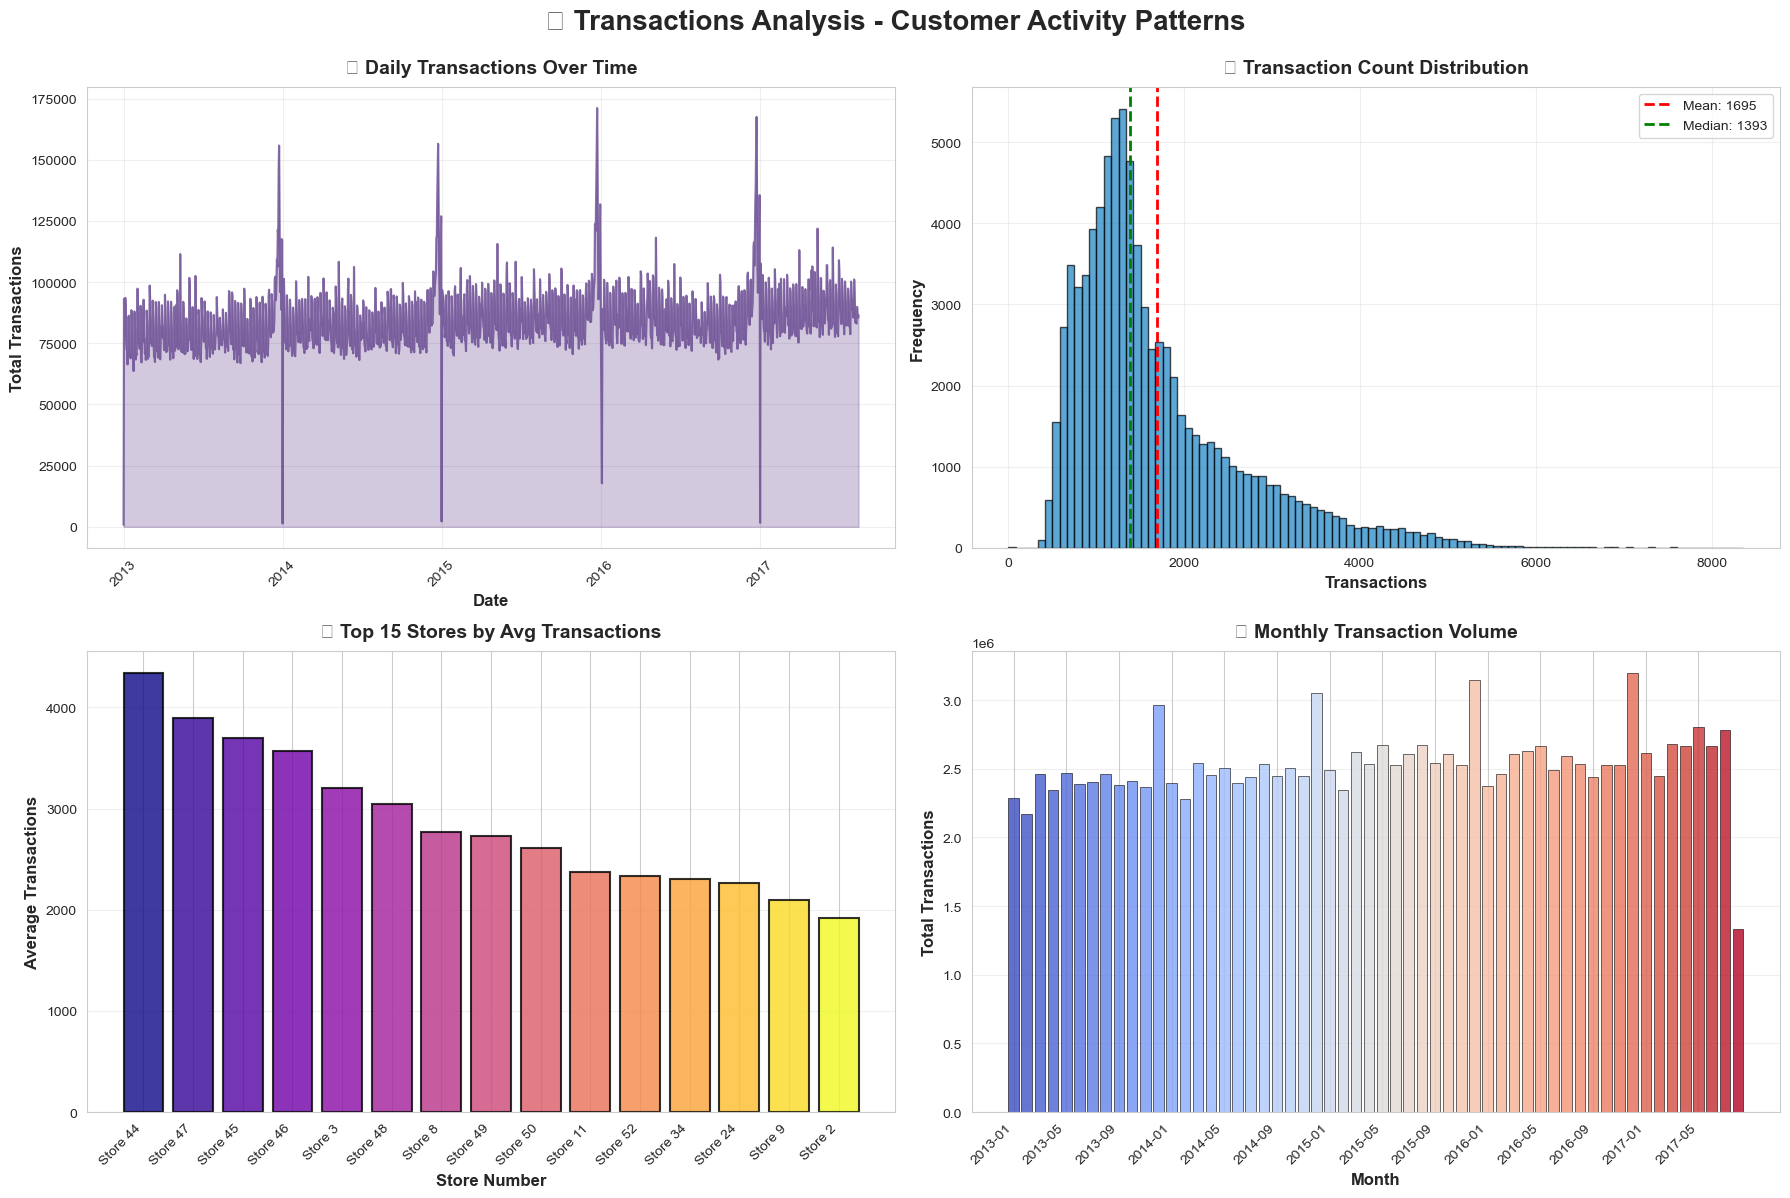


✅ Transactions analysis visualizations completed!


In [13]:
# Professional transactions visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('💳 Transactions Analysis - Customer Activity Patterns', fontsize=20, fontweight='bold', y=0.995)

# 1. Transactions Over Time
ax1 = axes[0, 0]
daily_trans = transactions.groupby('date')['transactions'].sum().reset_index()
ax1.plot(daily_trans['date'], daily_trans['transactions'], color='#6A4C93', linewidth=1.5, alpha=0.8)
ax1.fill_between(daily_trans['date'], daily_trans['transactions'], alpha=0.3, color='#6A4C93')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax1.set_title('📈 Daily Transactions Over Time', fontsize=14, fontweight='bold', pad=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# 2. Transaction Distribution
ax2 = axes[0, 1]
ax2.hist(transactions['transactions'], bins=100, color='#1982C4', edgecolor='black', alpha=0.7)
ax2.axvline(transactions['transactions'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {transactions["transactions"].mean():.0f}')
ax2.axvline(transactions['transactions'].median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {transactions["transactions"].median():.0f}')
ax2.set_xlabel('Transactions', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('📊 Transaction Count Distribution', fontsize=14, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Top 15 Stores by Average Transactions
ax3 = axes[1, 0]
store_avg_trans = transactions.groupby('store_nbr')['transactions'].mean().sort_values(ascending=False).head(15)
colors_stores = plt.cm.plasma(np.linspace(0, 1, len(store_avg_trans)))
bars = ax3.bar(range(len(store_avg_trans)), store_avg_trans.values, color=colors_stores, 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_xticks(range(len(store_avg_trans)))
ax3.set_xticklabels([f'Store {int(x)}' for x in store_avg_trans.index], rotation=45, ha='right')
ax3.set_xlabel('Store Number', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Transactions', fontsize=12, fontweight='bold')
ax3.set_title('🏆 Top 15 Stores by Avg Transactions', fontsize=14, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Monthly Transaction Trends
ax4 = axes[1, 1]
transactions['year_month'] = transactions['date'].dt.to_period('M')
monthly_trans = transactions.groupby('year_month')['transactions'].sum()
colors_monthly = plt.cm.coolwarm(np.linspace(0, 1, len(monthly_trans)))
ax4.bar(range(len(monthly_trans)), monthly_trans.values, color=colors_monthly, 
        edgecolor='black', linewidth=0.5, alpha=0.8)
ax4.set_xlabel('Month', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax4.set_title('📅 Monthly Transaction Volume', fontsize=14, fontweight='bold', pad=10)
ax4.set_xticks(range(0, len(monthly_trans), max(1, len(monthly_trans)//12)))
ax4.set_xticklabels([str(monthly_trans.index[i]) for i in range(0, len(monthly_trans), max(1, len(monthly_trans)//12))], 
                     rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Transactions analysis visualizations completed!")

---

### Step 6: Deep Dive - Sales Patterns & Correlations

Now let's explore deeper patterns, seasonality, and correlations between different factors.

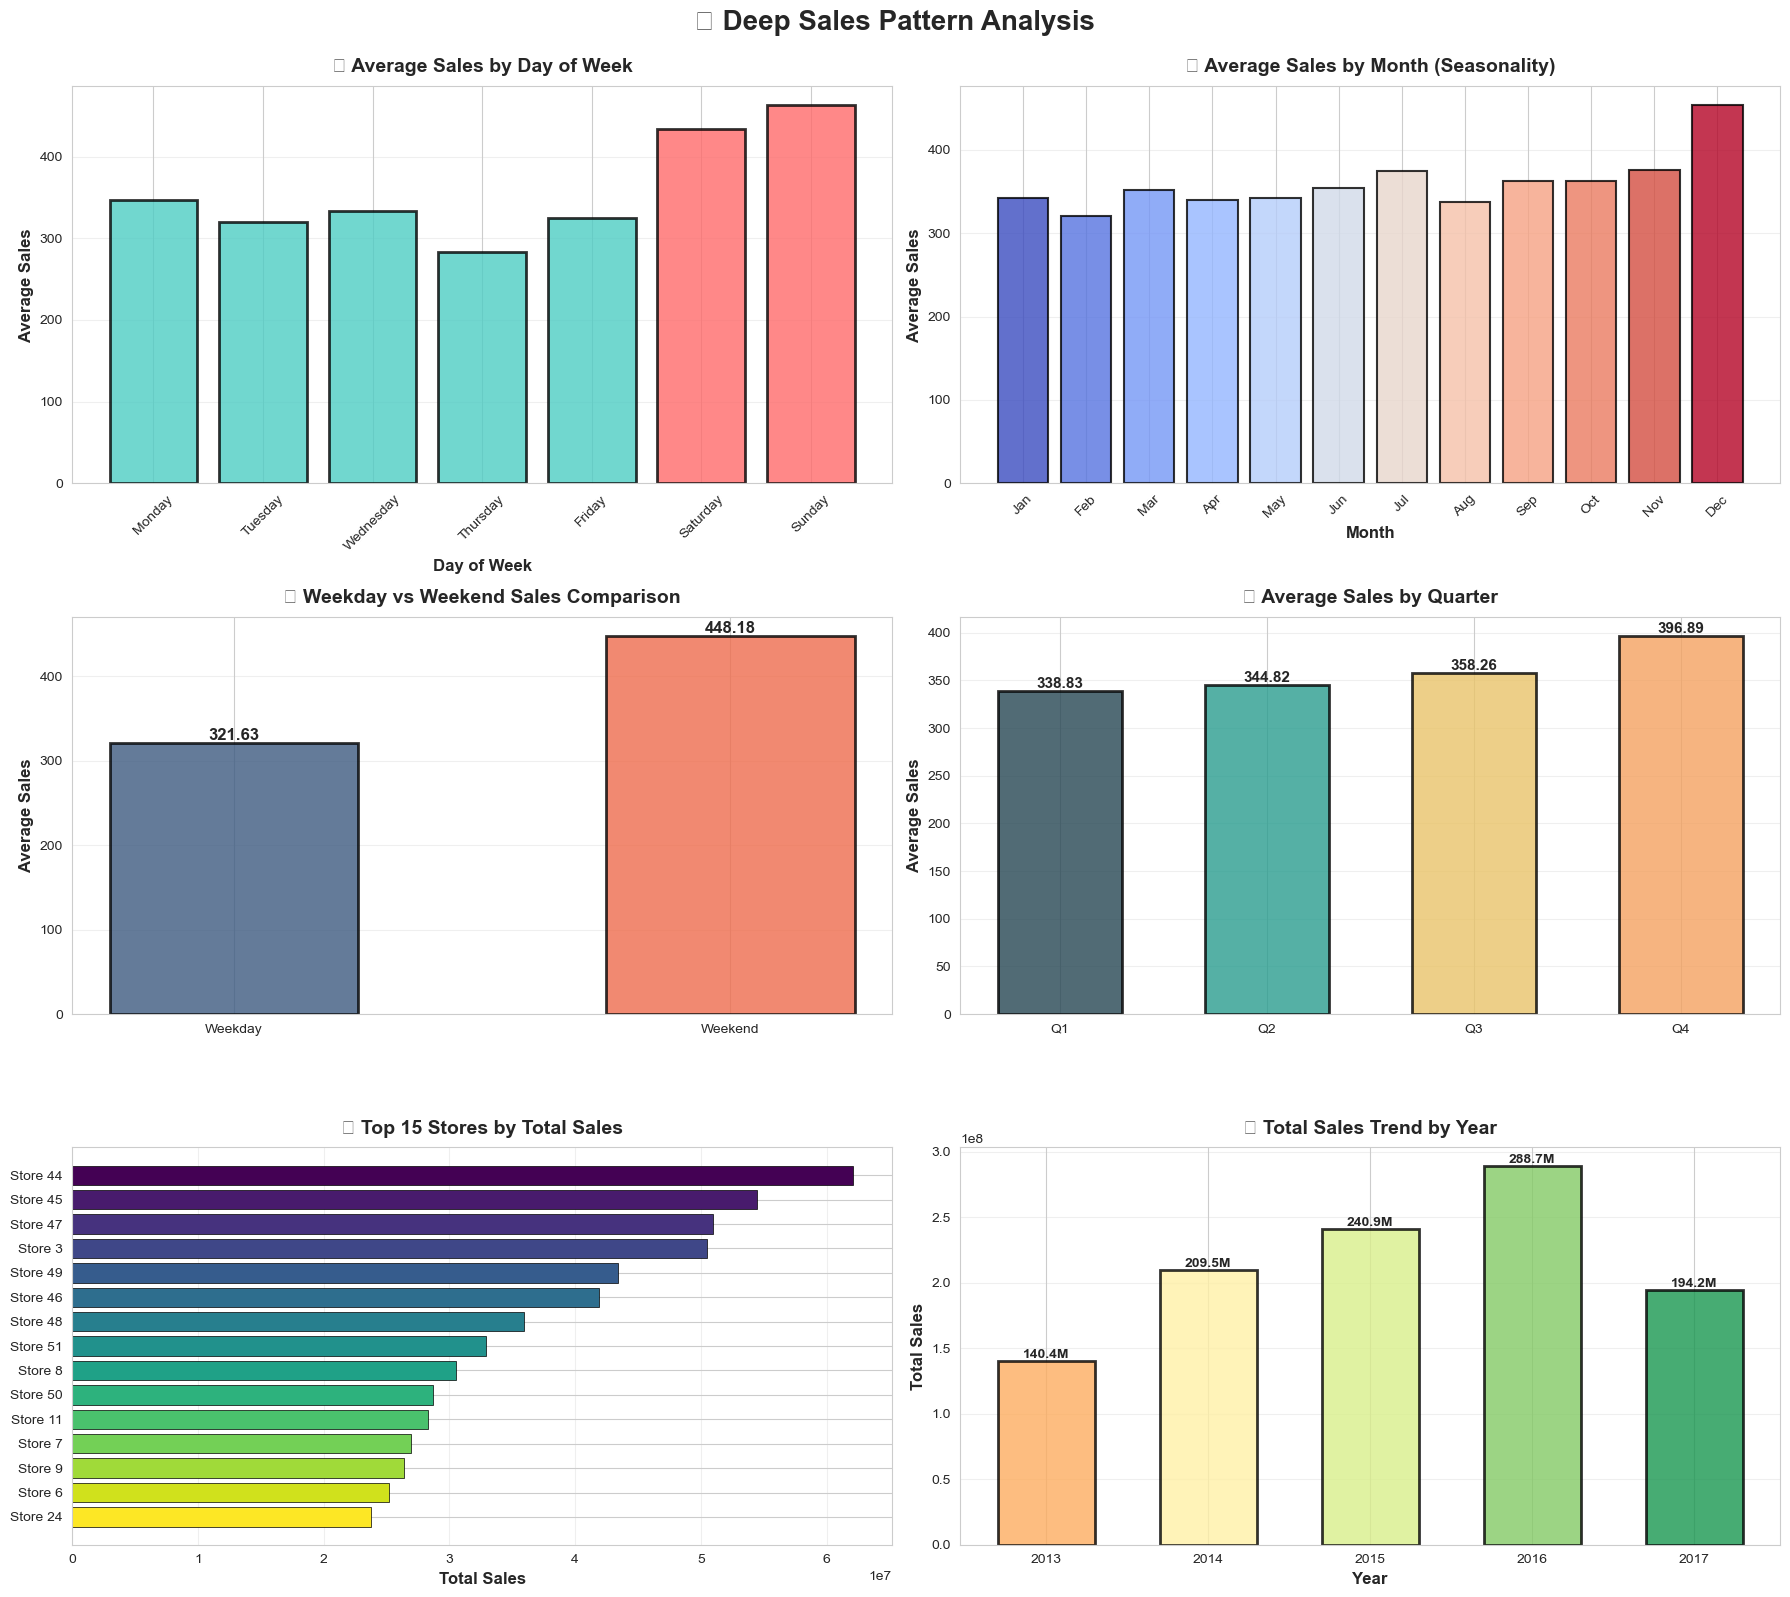


✅ Deep pattern analysis completed!


In [14]:
# Extract temporal features from training data
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['quarter'] = train['date'].dt.quarter
train['is_weekend'] = train['dayofweek'].isin([5, 6]).astype(int)

# Create advanced visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('🔬 Deep Sales Pattern Analysis', fontsize=20, fontweight='bold', y=0.995)

# 1. Sales by Day of Week
ax1 = axes[0, 0]
dow_sales = train.groupby('dayofweek')['sales'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors_dow = ['#FF6B6B' if i in [5, 6] else '#4ECDC4' for i in range(7)]
bars = ax1.bar(days, dow_sales.values, color=colors_dow, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Sales', fontsize=12, fontweight='bold')
ax1.set_title('📅 Average Sales by Day of Week', fontsize=14, fontweight='bold', pad=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. Sales by Month
ax2 = axes[0, 1]
monthly_sales = train.groupby('month')['sales'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors_month = plt.cm.coolwarm(np.linspace(0, 1, 12))
bars = ax2.bar(month_names, monthly_sales.values, color=colors_month, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Sales', fontsize=12, fontweight='bold')
ax2.set_title('📆 Average Sales by Month (Seasonality)', fontsize=14, fontweight='bold', pad=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. Weekday vs Weekend Sales
ax3 = axes[1, 0]
weekend_sales = train.groupby('is_weekend')['sales'].mean()
colors_we = ['#3D5A80', '#EE6C4D']
bars = ax3.bar(['Weekday', 'Weekend'], weekend_sales.values, color=colors_we, 
               edgecolor='black', linewidth=2, alpha=0.8, width=0.5)
ax3.set_ylabel('Average Sales', fontsize=12, fontweight='bold')
ax3.set_title('🔄 Weekday vs Weekend Sales Comparison', fontsize=14, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Sales by Quarter
ax4 = axes[1, 1]
quarterly_sales = train.groupby('quarter')['sales'].mean()
colors_q = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261']
bars = ax4.bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_sales.values, color=colors_q, 
               edgecolor='black', linewidth=2, alpha=0.8, width=0.6)
ax4.set_ylabel('Average Sales', fontsize=12, fontweight='bold')
ax4.set_title('📊 Average Sales by Quarter', fontsize=14, fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# 5. Top Stores by Total Sales
ax5 = axes[2, 0]
top_stores = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(15)
colors_top = plt.cm.viridis(np.linspace(0, 1, len(top_stores)))
bars = ax5.barh(range(len(top_stores)), top_stores.values, color=colors_top, 
                edgecolor='black', linewidth=0.5)
ax5.set_yticks(range(len(top_stores)))
ax5.set_yticklabels([f'Store {int(x)}' for x in top_stores.index], fontsize=10)
ax5.set_xlabel('Total Sales', fontsize=12, fontweight='bold')
ax5.set_title('🏪 Top 15 Stores by Total Sales', fontsize=14, fontweight='bold', pad=10)
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Sales Trend by Year
ax6 = axes[2, 1]
yearly_sales = train.groupby('year')['sales'].sum()
colors_year = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(yearly_sales)))
bars = ax6.bar(yearly_sales.index, yearly_sales.values, color=colors_year, 
               edgecolor='black', linewidth=2, alpha=0.8, width=0.6)
ax6.set_xlabel('Year', fontsize=12, fontweight='bold')
ax6.set_ylabel('Total Sales', fontsize=12, fontweight='bold')
ax6.set_title('📈 Total Sales Trend by Year', fontsize=14, fontweight='bold', pad=10)
ax6.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height/1e6:.1f}M',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Deep pattern analysis completed!")

---

### 📋 Key Insights & Summary

Let's summarize the key findings from our comprehensive exploratory data analysis.

In [15]:
# Generate comprehensive EDA summary
print("=" * 100)
print("📋 COMPREHENSIVE EDA SUMMARY - KEY INSIGHTS")
print("=" * 100)

print("\n🎯 DATASET OVERVIEW:")
print(f"   • Training Records: {len(train):,}")
print(f"   • Time Period: {train['date'].min()} to {train['date'].max()}")
print(f"   • Number of Stores: {train['store_nbr'].nunique()}")
print(f"   • Number of Product Families: {train['family'].nunique()}")

print("\n💰 SALES INSIGHTS:")
print(f"   • Total Sales: ${train['sales'].sum():,.2f}")
print(f"   • Average Daily Sales: ${train['sales'].mean():,.2f}")
print(f"   • Median Sales: ${train['sales'].median():,.2f}")
print(f"   • Sales Standard Deviation: ${train['sales'].std():,.2f}")

print("\n📊 PROMOTION IMPACT:")
promo_yes = train[train['onpromotion'] > 0]['sales'].mean()
promo_no = train[train['onpromotion'] == 0]['sales'].mean()
promo_lift = ((promo_yes - promo_no) / promo_no * 100)
print(f"   • Average Sales (Promoted): ${promo_yes:.2f}")
print(f"   • Average Sales (Not Promoted): ${promo_no:.2f}")
print(f"   • Promotion Lift: {promo_lift:.2f}%")

print("\n🏪 STORE CHARACTERISTICS:")
print(f"   • Total Stores: {stores.shape[0]}")
print(f"   • Store Types: {stores['type'].nunique()}")
print(f"   • Cities Covered: {stores['city'].nunique()}")
print(f"   • States Covered: {stores['state'].nunique()}")

print("\n🛢️ OIL PRICE INSIGHTS:")
oil_clean = oil.dropna()
print(f"   • Average Oil Price: ${oil_clean['dcoilwtico'].mean():.2f}")
print(f"   • Oil Price Range: ${oil_clean['dcoilwtico'].min():.2f} - ${oil_clean['dcoilwtico'].max():.2f}")
print(f"   • Oil Price Volatility (Std): ${oil_clean['dcoilwtico'].std():.2f}")

print("\n🎉 HOLIDAYS & EVENTS:")
print(f"   • Total Holiday/Event Records: {len(holidays_events)}")
print(f"   • National Holidays: {len(holidays_events[holidays_events['locale'] == 'National'])}")
print(f"   • Regional Events: {len(holidays_events[holidays_events['locale'] == 'Regional'])}")
print(f"   • Local Events: {len(holidays_events[holidays_events['locale'] == 'Local'])}")

print("\n💳 TRANSACTION PATTERNS:")
print(f"   • Total Transaction Records: {len(transactions):,}")
print(f"   • Average Daily Transactions per Store: {transactions['transactions'].mean():.0f}")
print(f"   • Peak Transaction Day: {transactions.groupby('date')['transactions'].sum().idxmax()}")

print("\n🔍 TEMPORAL PATTERNS:")
best_day = days[train.groupby('dayofweek')['sales'].mean().idxmax()]
best_month = month_names[train.groupby('month')['sales'].mean().idxmax() - 1]
print(f"   • Best Sales Day: {best_day}")
print(f"   • Best Sales Month: {best_month}")
print(f"   • Weekend vs Weekday Avg Sales Ratio: {weekend_sales.iloc[1] / weekend_sales.iloc[0]:.2f}x")

print("\n🏆 TOP PERFORMERS:")
top_family = train.groupby('family')['sales'].sum().idxmax()
top_store = train.groupby('store_nbr')['sales'].sum().idxmax()
print(f"   • Top Product Family: {top_family}")
print(f"   • Top Store: Store #{int(top_store)}")

print("\n" + "=" * 100)
print("✅ EDA COMPLETED - Ready for Feature Engineering & Modeling!")
print("=" * 100)

📋 COMPREHENSIVE EDA SUMMARY - KEY INSIGHTS

🎯 DATASET OVERVIEW:
   • Training Records: 3,000,888
   • Time Period: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
   • Number of Stores: 54
   • Number of Product Families: 33

💰 SALES INSIGHTS:
   • Total Sales: $1,073,644,952.20
   • Average Daily Sales: $357.78
   • Median Sales: $11.00
   • Sales Standard Deviation: $1,102.00

📊 PROMOTION IMPACT:
   • Average Sales (Promoted): $1137.69
   • Average Sales (Not Promoted): $158.25
   • Promotion Lift: 618.94%

🏪 STORE CHARACTERISTICS:
   • Total Stores: 54
   • Store Types: 5
   • Cities Covered: 22
   • States Covered: 16

🛢️ OIL PRICE INSIGHTS:
   • Average Oil Price: $67.71
   • Oil Price Range: $26.19 - $110.62
   • Oil Price Volatility (Std): $25.63

🎉 HOLIDAYS & EVENTS:
   • Total Holiday/Event Records: 350
   • National Holidays: 174
   • Regional Events: 24
   • Local Events: 152

💳 TRANSACTION PATTERNS:
   • Total Transaction Records: 83,488
   • Average Daily Transactions per Store